Epoch [1/20], Loss: 0.0471
Epoch [2/20], Loss: 0.0398
Epoch [3/20], Loss: 0.0376
Epoch [4/20], Loss: 0.0320
Epoch [5/20], Loss: 0.0294
Epoch [6/20], Loss: 0.0318
Epoch [7/20], Loss: 0.0282
Epoch [8/20], Loss: 0.0271
Epoch [9/20], Loss: 0.0262
Epoch [10/20], Loss: 0.0285
Epoch [11/20], Loss: 0.0286
Epoch [12/20], Loss: 0.0249
Epoch [13/20], Loss: 0.0248
Epoch [14/20], Loss: 0.0243
Epoch [15/20], Loss: 0.0238
Epoch [16/20], Loss: 0.0224
Epoch [17/20], Loss: 0.0254
Epoch [18/20], Loss: 0.0243
Epoch [19/20], Loss: 0.0219
Epoch [20/20], Loss: 0.0217


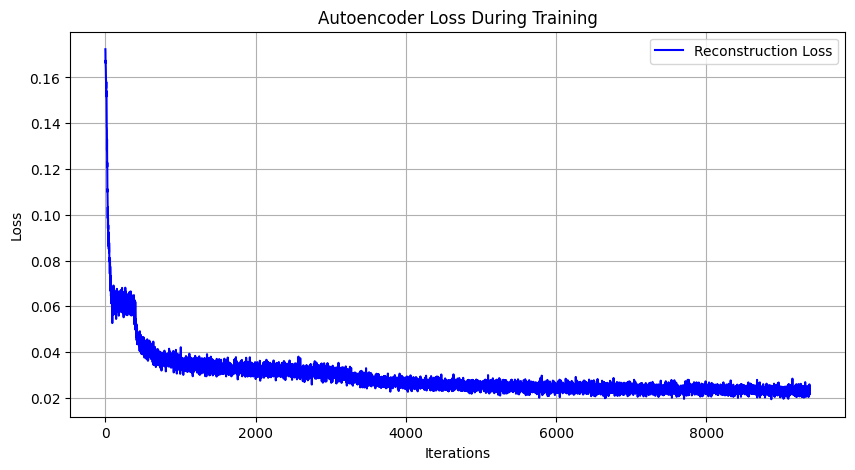

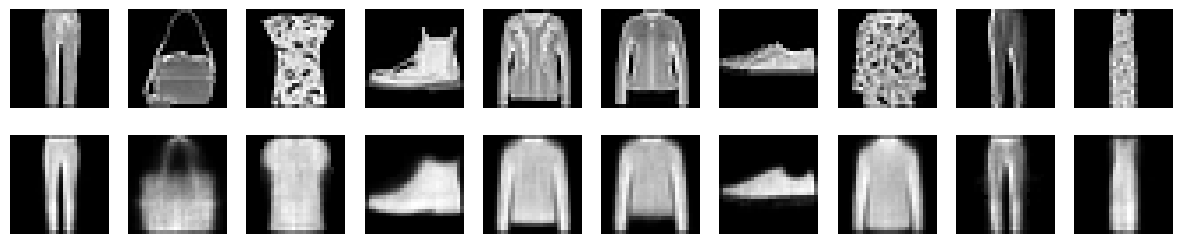

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder: Gradually compress the input image into a 3-dimensional latent space
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),  # Convert the input vector (784 dimensions) to 128 dimensions
            nn.ReLU(True),
            nn.Linear(128, 64),     # 128 dimensions -> 64 dimensions
            nn.ReLU(True),
            nn.Linear(64, 12),      # 64 dimensions -> 12 dimensions
            nn.ReLU(True),
            nn.Linear(12, 3)        # Finally compress into a 3-dimensional latent variable
        )
        # Decoder: Reconstruct an output similar to the original image from the latent variable
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Sigmoid()  # Restrict the output range to 0~1 (suitable for image pixel values)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Set up the dataset and dataloader
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

# Configure the model, loss function, and optimization algorithm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()  # Loss function to measure reconstruction error
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Add list to track batch-level losses
batch_losses = []

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data  # Although FashionMNIST includes labels, only the input is used in an Autoencoder
        img = img.view(img.size(0), -1).to(device)  # Reshape the 28x28 image into a 1-dimensional vector (784 dimensions)
        # Forward propagation: Encoding and decoding for reconstruction
        output = model(img)
        loss = criterion(output, img)  # Calculate the MSE loss between the original and reconstructed image

        # Backpropagation and weight update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Inside the training loop, after optimizer.step():
        # Track loss at batch level for visualization
        batch_losses.append(loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# After training completes:
# Plot the loss curve to visualize training progress
plt.figure(figsize=(10, 5))
plt.title("Autoencoder Loss During Training")
plt.plot(batch_losses, color='blue', label="Reconstruction Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Test and visualize the results
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=10, shuffle=True)
dataiter = iter(test_loader)
images, _ = next(dataiter)
images_flat = images.view(images.size(0), -1).to(device)
reconstructed = model(images_flat)
reconstructed = reconstructed.view(-1, 1, 28, 28).cpu().detach()

# Compare original and reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(15, 3))
for i in range(10):
    axes[0, i].imshow(images[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')
plt.show()